Importing needed libraries

In [2]:
import math
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import statsmodels.api as sm

Importing Datasets from Yahoo Finance

In [3]:
JPM = yf.download('JPM',start='2008-01-01',end='2009-12-31',progress=False)
MS = yf.download('MS',start='2008-01-01',end='2009-12-31',progress=False)
C = yf.download('C',start='2008-01-01',end='2009-12-31',progress=False)
GS = yf.download('GS',start='2008-01-01',end='2009-12-31',progress=False)

<Figure size 1600x800 with 0 Axes>

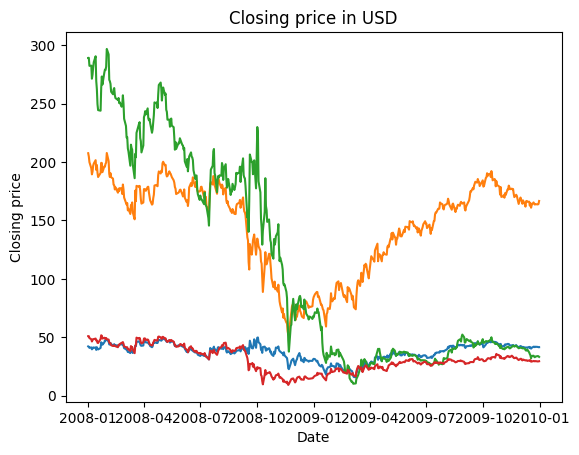

<Figure size 1600x800 with 0 Axes>

In [4]:
plt.title("Closing price in USD")
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.plot(JPM["Close"])
plt.plot(GS["Close"])
plt.plot(C["Close"])
plt.plot(MS["Close"])
plt.figure(figsize=(16,8))



In [5]:
file_path = "C:\\Users\\medda\\Desktop\\AF\\pythonProject\\Data\\4BanksFinancial crisis.xlsx"
portfolio = pd.read_excel(file_path, parse_dates = ['Date'], index_col='Date')
portfolio

,C,GS,MS,JPM
Date,,,,
2008-01-02,226.216690,165.462845,37.880886,28.931559
2008-01-03,226.294739,163.263046,37.873447,28.732595
2008-01-04,220.897568,159.349594,36.654118,28.080833
2008-01-07,221.054001,155.205048,35.918064,28.362110
2008-01-08,212.293198,151.036652,34.498005,27.236961
...,...,...,...,...
2009-12-23,27.225204,133.173279,23.022058,29.781374
2009-12-24,27.721704,133.450012,23.170799,30.017851
2009-12-28,28.052713,133.279068,22.928125,29.896032


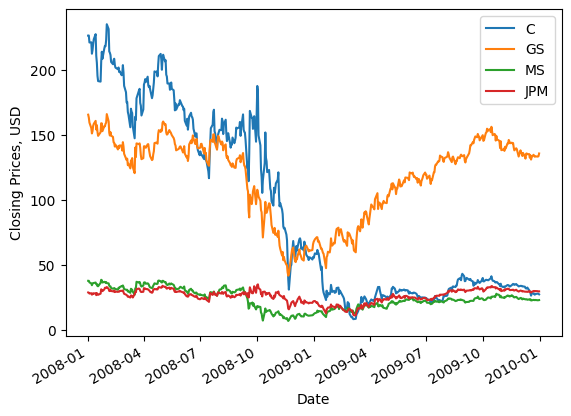

In [6]:
# Select portfolio asset prices for the middle of the crisis, 2008-2009
asset_prices = portfolio.loc['2008-01-01':'2009-12-31']

# Plot portfolio's asset prices during this time
asset_prices.plot().set_ylabel("Closing Prices, USD")
plt.show()

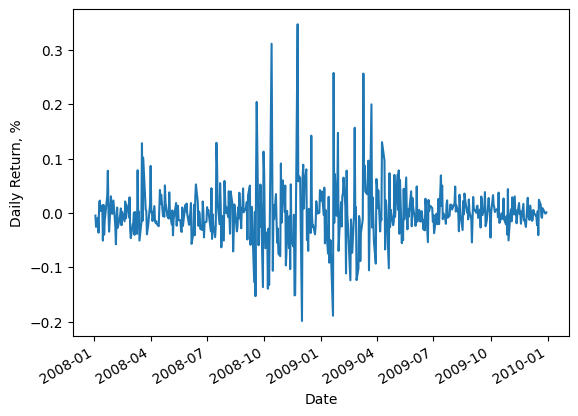

In [7]:
# Compute the portfolio's daily returns
asset_returns = asset_prices.pct_change()

# set the weights : make sure your weights are in an Array not list, becuase list does not have transpose and give error 
# when you try to calculate the variance of your portfolio
weights = np.array([0.25, 0.25, 0.25, 0.25])

portfolio_returns = asset_returns.dot(weights)



# Plot portfolio returns
portfolio_returns.plot().set_ylabel("Daily Return, %")
plt.show()

Asset covariance and portfolio volatility
Now that you've examined the return of the portfolio of investment banks, it's time to assess the riskiness of the portfolio using the covariance matrix to determine the portfolio's volatility.

First you'll compute the covariance between the asset_returns and identify which of the banks had the highest volatility during the 2008-2009 crisis period.

Then, given the weights of an equal-weighted portfolio, you'll find the portfolio's annualized volatility for that period using portfolio_returns.

Finally, you'll use a 30-day window to create a time series of the volatility, and visualize this with a plot.

In [8]:
# Generate the covariance matrix from portfolio asset's returns
covariance = asset_returns.cov()

# Annualize the covariance using 252 trading days per year
covariance = covariance * 252

# Display the covariance matrix
print(covariance)

            C        GS        MS       JPM
C    1.479025  0.574099  0.824979  0.726839
GS   0.574099  0.501550  0.660386  0.427935
MS   0.824979  0.660386  1.301330  0.562200
JPM  0.726839  0.427935  0.562200  0.686832


In [9]:
# Compute and display portfolio volatility for 2008 - 2009
portfolio_variance = np.transpose(weights) @ covariance @ weights
portfolio_volatility = np.sqrt(portfolio_variance)
print(portfolio_volatility)

0.8485875040007894


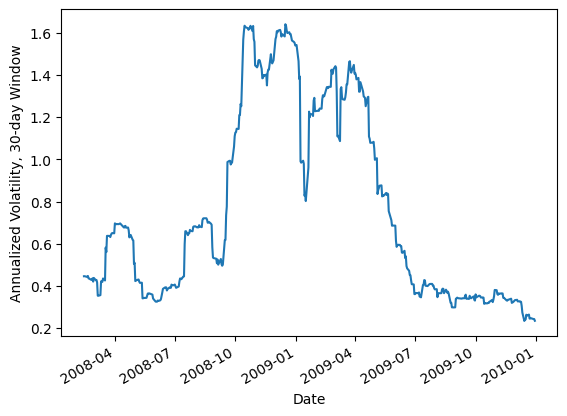

In [10]:
# Calculate the 30-day rolling window of portfolio returns
returns_windowed = portfolio_returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the portfolio volatility
volatility_series.plot().set_ylabel("Annualized Volatility, 30-day Window")
plt.show()

Citibank exhibited the highest volatility during the crisis period, with Morgan Stanley not far behind. The volatility plot shows that an equal-weighted portfolio of all four banks demonstrated a significant increase in volatility from late September 2008, which is around the time the 4th-largest investment bank in the world, Lehman Brothers, went bankrupt. Its bankruptcy was largely due to mismanagement of the risks associated with its holdings of mortgage-backed securities.

# **Frequency resampling primer**

Risk factor models often rely upon data that is of different frequencies. A typical example is when using quarterly macroeconomic data, such as prices, unemployment rates, etc., with financial data, which is often daily (or even intra-daily). To use both data sources in the same model, higher frequency data needs to be resampled to match the lower frequency data.

The DataFrame and Series Pandas objects have a built-in .resample() method that specifies the lower frequency. This method is chained with a method to create the lower-frequency statistic, such as .mean() for the average of the data within the new frequency period, or .min() for the minimum of the data.

In this exercise you'll practice converting daily returns data to weekly and quarterly frequency.

In [11]:
# Convert daily returns to quarterly average returns
returns_q = asset_returns.resample('Q').mean()

# Examine the beginning of the quarterly series
print(returns_q.resample('Q'))

# Now convert daily returns to weekly minimum returns
returns_w = asset_returns.resample('W').min()

# Examine the beginning of the weekly series
print(returns_w.resample('W'))

DatetimeIndexResampler [freq=<QuarterEnd: startingMonth=12>, axis=0, closed=right, label=right, convention=start, origin=start_day]
DatetimeIndexResampler [freq=<Week: weekday=6>, axis=0, closed=right, label=right, convention=start, origin=start_day]


# **Visualizing risk factor correlation**
Investment banks heavily invested in mortgage-backed securities (MBS) before and during the financial crisis. This makes MBS a likely risk factor for the investment bank portfolio. You'll assess this using scatterplots between portfolio returns and an MBS risk measure, the 90-day mortgage delinquency rate mort_del.

mort_del is only available as quarterly data. So portfolio_returns first needs to be transformed from daily to quarterly frequency using the DataFrame .resample() method.

Your workspace contains both portfolio_returns for an equal-weighted portfolio and the delinquency rate mort_del variable. For the scatterplots, plot_average and plot_min are plot axes in your workspace--you'll add your scatterplots to them using the .scatter() method.

In [12]:
#filepath = "C:\\Users\\medda\\Downloads\\National_Delinquency_Rates_in_the_United_States (1).xlsx"
#mort_del= pd.read_excel(filepath, sheet_name='Table',skiprows=5,skipfooter=2)
#mort_del["Percent Delinquent\n90 Days or More"]


In [13]:
filepath = "C:\\Users\\medda\\Downloads\\National_Delinquency_Rates_in_the_United_States.xlsx"
mort_del= pd.read_excel(filepath, sheet_name='Table')
#mort_del["Percent Delinquent\n90 Days or More"]

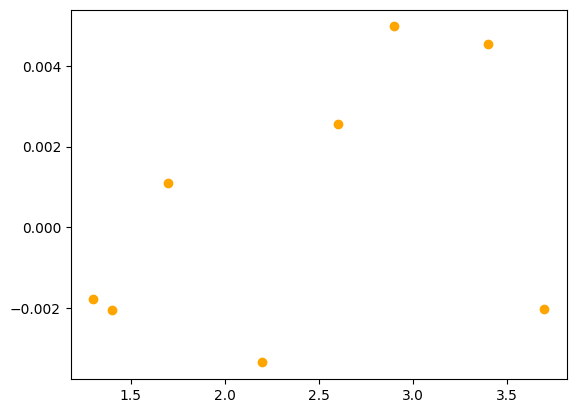

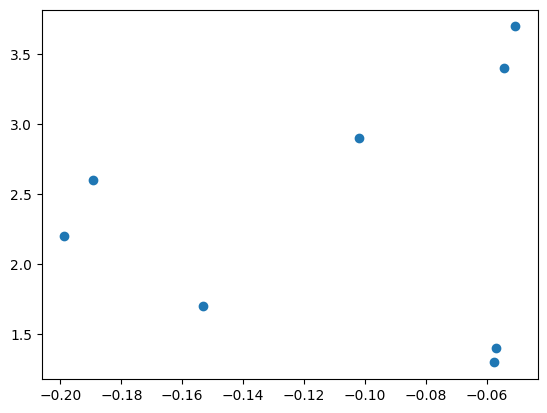

In [14]:
# Transform the daily portfolio_returns into quarterly average returns
portfolio_q_average = portfolio_returns.resample('Q').mean().dropna()

# Create a scatterplot between delinquency and quarterly average returns
plt.scatter(mort_del["Percent Delinquent\n90 Days or More"], portfolio_q_average,color='orange')
plt.show()
# Transform daily portfolio_returns returns into quarterly minimum returns
portfolio_q_min = portfolio_returns.resample('Q').min().dropna()

# Create a scatterplot between delinquency and quarterly minimum returns
plt.scatter(portfolio_q_min,mort_del["Percent Delinquent\n90 Days or More"])
plt.show()

#Transform the daily portfolio_returns into quarterly average returns
portfolio_q_average = portfolio_returns.resample('Q').mean().dropna()

#Create a scatterplot between delinquency and quarterly average returns
plot_average.scatter(mort_del, portfolio_q_average)

#Transform daily portfolio_returns returns into quarterly minimum returns
portfolio_q_min = portfolio_returns.resample('Q').min().dropna()

#Create a scatterplot between delinquency and quarterly minimum returns
plot_min.scatter(mort_del, portfolio_q_min)
plt.show()

Your initial assessment indicates that there is little correlation between average returns and mortgage delinquencies, but a stronger negative correlation exists between minimum returns and delinquency. In the following exercises you'll quantify this using least-squares regression.

# Least-squares factor model

As you've seen, there is a negative correlation between minimum quarterly returns and mortgage delinquency rates from 2005 - 2010. This can be made more precise with an OLS regression factor model.

You'll compare three factor models with three different quarterly dependent variables: average returns, minimum returns, and average volatility. The independent variable is the mortgage delinquency rate. In the regression summary, examine the coefficients' t-statistic for statistical significance, as well as the overall R-squared for goodness of fit.

The statsmodels.api library is available as sm

In [15]:
df = portfolio_q_average
shape = df.shape
print(shape)

(8,)


In [16]:
# Add a constant to the regression
mort_del = sm.add_constant(mort_del["Percent Delinquent\n90 Days or More"])
x= mort_del["Percent Delinquent\n90 Days or More"]
y = list(portfolio_q_average)
# Create the regression factor model and fit it to the data
results = sm.OLS(y, x).fit()

# Print a summary of the results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.086
Model:                            OLS   Adj. R-squared (uncentered):             -0.045
Method:                 Least Squares   F-statistic:                             0.6579
Date:                Fri, 30 Dec 2022   Prob (F-statistic):                       0.444
Time:                        19:09:44   Log-Likelihood:                          35.280
No. Observations:                   8   AIC:                                     -68.56
Df Residuals:                       7   BIC:                                     -68.48
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------

c:\Users\medda\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [17]:
# Add a constant to the regression
mort_del = sm.add_constant(mort_del)

# Create the regression factor model and fit it to the data
x=list(portfolio_q_min)
y=mort_del
results = sm.OLS(x, y).fit()

# Print a summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.142
Method:                 Least Squares   F-statistic:                    0.1297
Date:                Fri, 30 Dec 2022   Prob (F-statistic):              0.731
Time:                        19:09:44   Log-Likelihood:                 11.324
No. Observations:                   8   AIC:                            -18.65
Df Residuals:                       6   BIC:                            -18.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

c:\Users\medda\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [58]:
# Add a constant to the regression
mort_del = sm.add_constant(mort_del)

portfolio_q_vol= portfolio_returns.resample('Q').std()

x=list(portfolio_q_vol)
y=mort_del
results = sm.OLS(x, y).fit()
# Print a summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                 -0.115
Method:                 Least Squares   F-statistic:                    0.2763
Date:                Fri, 30 Dec 2022   Prob (F-statistic):              0.618
Time:                        19:37:19   Log-Likelihood:                 17.935
No. Observations:                   8   AIC:                            -31.87
Df Residuals:                       6   BIC:                            -31.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

c:\Users\medda\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


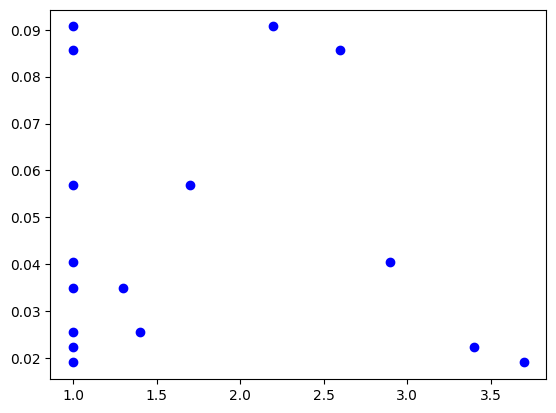

In [59]:
# Create a scatterplot between delinquency and quarterly minimum returns
plt.plot(mort_del, portfolio_q_vol, 'o', color='blue')
plt.show()